<a href="https://colab.research.google.com/github/Johnpaul10j/machine-learning1/blob/main/Evaluating_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Evaluating Random Forest Performance
Estimated time needed: **30** minutes
    

## Objectives


After completing this lab, you will be able to:

* Implement and evaluate the performance of random forest regression models on real-world data
* Interpret various evaluation metrics and visualizations
* Describe the feature importances for a regression model


## Introduction
In this lab, you will:
- Use the California Housing data set included in scikit-learn to predict the median house price based on various attributes
- Create a random forest regression model and evaluate its performance
- Investigate the feature importances for the model


Your goal in this lab is **not** to find the best regressor - it is primarily intended for you to practice interpreting modelling results in the context of a real-world problem.


Before you start, make sure that all the required libraries are installed. Execute the cell below for the same.


In [1]:
!pip install numpy==2.2.0
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3
!pip install scipy==1.14.1

  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 130.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 111.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found exi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 456.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 23.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


## Import the required libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import skew

### Load the California Housing data set


In [11]:
import pandas as pd
import numpy as np
from sklearn.utils import Bunch # Required to mimic sklearn's dataset object

# URL for an alternative California Housing dataset CSV
csv_url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"

# Load the dataset from the alternative source
try:
    housing_df = pd.read_csv(csv_url)

    # Handle missing values (e.g., 'total_bedrooms') by dropping rows for simplicity
    housing_df.dropna(inplace=True)

    # Create new features to match scikit-learn's California Housing dataset structure
    # The original dataset provides 'average' values per household/block group
    housing_df['AveRooms'] = housing_df['total_rooms'] / housing_df['households']
    housing_df['AveBedrms'] = housing_df['total_bedrooms'] / housing_df['households']
    housing_df['AveOccup'] = housing_df['population'] / housing_df['households']

    # Define the features to be used, selecting columns that correspond to the original scikit-learn dataset
    feature_cols_from_csv = [
        'median_income', 'housing_median_age', 'AveRooms', 'AveBedrms',
        'population', 'AveOccup', 'latitude', 'longitude'
    ]

    # Define feature names to be consistent with the original scikit-learn dataset's `feature_names` attribute
    new_feature_names = [
        'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
        'Population', 'AveOccup', 'Latitude', 'Longitude'
    ]

    # Extract features (X) and target (y) as NumPy arrays
    X = housing_df[feature_cols_from_csv].values
    # Scale target to match the original dataset (median house value in hundreds of thousands of dollars)
    y = (housing_df['median_house_value'] / 100000.0).values

    # Create a Bunch object to mimic sklearn.datasets.fetch_california_housing output structure
    data = Bunch(data=X, target=y, feature_names=new_feature_names,
                 DESCR="""California Housing dataset loaded from an alternative CSV source (Ageron's Hands-on ML2).

This dataset is derived from the 1990 U.S. census, using summary statistics for block groups in California. The target is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000)."""
                )
    print("California Housing dataset loaded successfully from alternative source.")

except Exception as e:
    print(f"Error loading California Housing dataset from alternative source: {e}")
    print("Please check the URL or try another source if this problem persists.")
    data, X, y = None, None, None # Set to None if alternative download fails

California Housing dataset loaded successfully from alternative source.


### Print the description of the California Housing data set


In [12]:
print(data.DESCR)

California Housing dataset loaded from an alternative CSV source (Ageron's Hands-on ML2).

This dataset is derived from the 1990 U.S. census, using summary statistics for block groups in California. The target is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).


### Exercise 1. Split the data into training and testing sets
Reserve 20% of the data for evaluation


In [13]:
# Enter your code here
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

<details><summary>Click here for the solution</summary>

```python
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

```

</details>


## Explore the training data


In [14]:
eda = pd.DataFrame(data=X_train)
eda.columns = data.feature_names
eda['MedHouseVal'] = y_train
eda.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000
mean,3.870697,28.615013,5.424986,1.096207,1420.589991,3.100228,35.640569,-119.580513,2.066444
std,1.897825,12.577173,2.359876,0.428815,1129.376716,11.650505,2.136181,2.005898,1.150552
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.564550,18.000000,4.441144,1.005926,787.000000,2.432191,33.930000,-121.810000,1.193000
50%,3.536650,29.000000,5.229129,1.048825,1165.000000,2.821563,34.260000,-118.510000,1.801000
75%,4.750000,37.000000,6.049917,1.099696,1720.000000,3.278760,37.720000,-118.010000,2.638000
max,15.000100,52.000000,141.909091,25.636364,35682.000000,1243.333333,41.950000,-114.470000,5.000010


### Exercise 2. What range are most of the median house prices valued at?


In [ ]:
#### Please enter your descriptive answer here and change the cell type to "Markdown" for formatting.


<details><summary>Click here for the solution</summary>
Considering the 25th to the 75th percentile range, most of the median house prices fall within \$119,300 and \$265,000.

</details>


### How are the median house prices distributed?


Text(0, 0.5, 'Frequency')

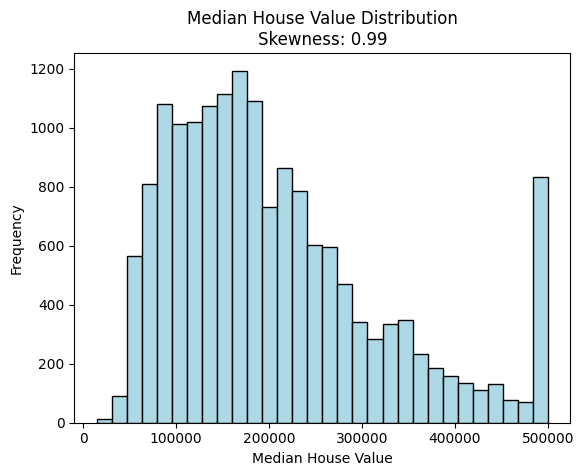

In [15]:
# Plot the distribution
plt.hist(1e5*y_train, bins=30, color='lightblue', edgecolor='black')
plt.title(f'Median House Value Distribution\nSkewness: {skew(y_train):.2f}')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')

Evidently the distribution is skewed and there are quite a few clipped values at around $500,000.


### Model fitting and prediction
Let's fit a random forest regression model to the data and use it to make median house price predicions.
Use the default parameters, which includes using 100 base estimators, or regression trees.


In [16]:
# Initialize and fit the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on test set
y_pred_test = rf_regressor.predict(X_test)

### Estimate out-of-sample MAE, MSE, RMSE, and R²


In [17]:
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.3350
Mean Squared Error (MSE): 0.2688
Root Mean Squared Error (RMSE): 0.5184
R² Score: 0.8035


### Exercise 3. What do these statistics mean to you?
How comfortable could you be with stopping here and communicating the results to the C-suite?


In [ ]:
#### Please enter your descriptive answer here and change the cell type to "Markdown" for formatting.


<details><summary>Click here for the solution</summary>
<p>The mean absolute error is $33,220.</p>

<p>So, on average, predicted median house prices are off by \$33k.</p>
Mean squared error is less intuitive to interpret, but is usually what is being minimized by the model fit.

On the other hand, taking the square root of MSE yields a dollar value, here RMSE = \$50,630.

An R-squared score of 0.80 is not considered very high. It means the model explains about %80 of the variance in median house prices, although this interpretation can be misleading for compex data with nonlinear relationships, skewed values, and outliers. R-squard can still be useful for comparing models though.

These statistics alone don't explain any details about the performance of the model.
For example, where did the model do well or poorly?

We aren't done yet!</details>




### Plot Actual vs Predicted values


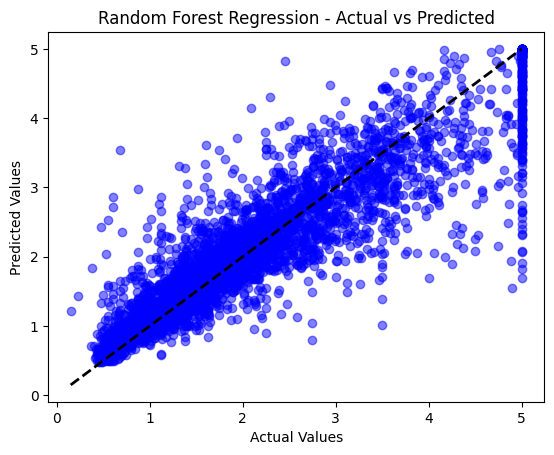

In [18]:
plt.scatter(y_test, y_pred_test, alpha=0.5, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regression - Actual vs Predicted")
plt.show()

### Exercise 4. Plot the histogram of the residual errors (dollars)
Also, print the mean and standard deviation of the residuals.
Check for any patterns.


Average error = 511
Standard deviation of error = 51840


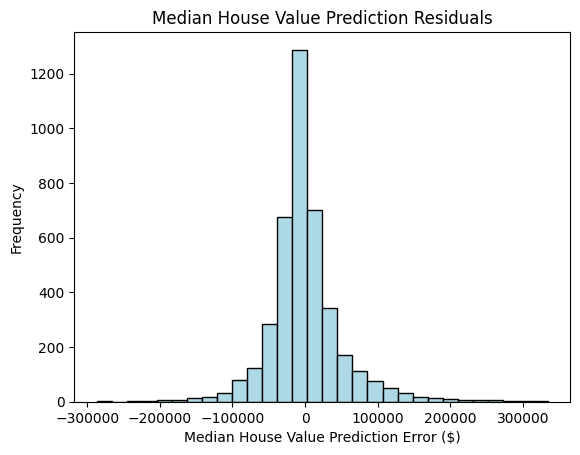

In [19]:
# Calculate the residual errors
residuals = 1e5*(y_test - y_pred_test)

# Plot the histogram of the residuals
plt.hist(residuals, bins=30, color='lightblue', edgecolor='black')
plt.title(f'Median House Value Prediction Residuals')
plt.xlabel('Median House Value Prediction Error ($)')
plt.ylabel('Frequency')
print('Average error = ' + str(int(np.mean(residuals))))
print('Standard deviation of error = ' + str(int(np.std(residuals))))

<details><summary>Click here for the solution</summary>
    
```python
    
# Calculate the residual errors
residuals = 1e5*(y_test - y_pred_test)

# Plot the histogram of the residuals
plt.hist(residuals, bins=30, color='lightblue', edgecolor='black')
plt.title(f'Median House Value Prediction Residuals')
plt.xlabel('Median House Value Prediction Error ($)')
plt.ylabel('Frequency')
print('Average error = ' + str(int(np.mean(residuals))))
print('Standard deviation of error = ' + str(int(np.std(residuals))))
```


The residuals are normally distributed with a very small average error and a standard deviation of about \$50,000.


### Exercise 5. Plot the model residual errors by median house value.
Sort the residuals by actual median house value before plotting the residuals.

Check for any patterns.


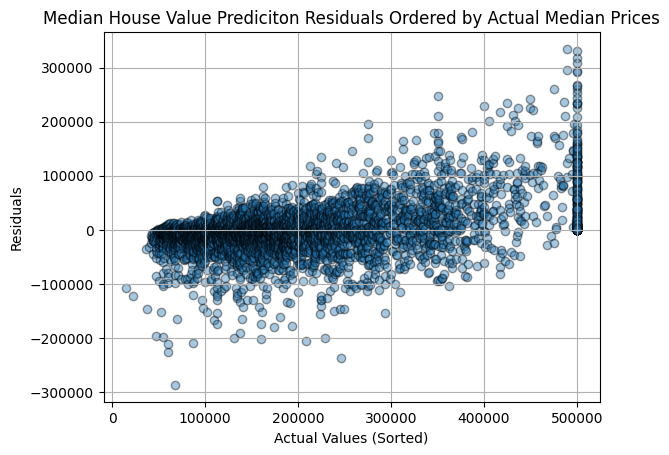

In [20]:
# Create a DataFrame to make sorting easy
residuals_df = pd.DataFrame({
    'Actual': 1e5*y_test,
    'Residuals': residuals
})

# Sort the DataFrame by the actual target values
residuals_df = residuals_df.sort_values(by='Actual')

# Plot the residuals
plt.scatter(residuals_df['Actual'], residuals_df['Residuals'], marker='o', alpha=0.4,ec='k')
plt.title('Median House Value Prediciton Residuals Ordered by Actual Median Prices')
plt.xlabel('Actual Values (Sorted)')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

<details><summary>Click here for the solution</summary>
    
```python
    
# Create a DataFrame to make sorting easy
residuals_df = pd.DataFrame({
    'Actual': 1e5*y_test,
    'Residuals': residuals
})

# Sort the DataFrame by the actual target values
residuals_df = residuals_df.sort_values(by='Actual')

# Plot the residuals
plt.scatter(residuals_df['Actual'], residuals_df['Residuals'], marker='o', alpha=0.4,ec='k')
plt.title('Median House Value Prediciton Residuals Ordered by Actual Median Prices')
plt.xlabel('Actual Values (Sorted)')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()
```


### Exercise 6. What trend can you infer from this residual plot?


In [ ]:
#### Please enter your descriptive answer here and change the cell type to "Markdown" for formatting.



<details><summary>Click here for the solution</summary>
Although we saw a small average residual of only -\$1400, you can see from this plot that the average error as a function of median house price is actually increasing from negative to positive values.
In other words, lower median prices tend to be overpredicted while higher median prices tend to be underpredicted.    
</details>


### Exercise 7. Display the feature importances as a bar chart.
Do you think these feature weights have practial significance? Are any of the features possibly sharing importance with other correlated features?


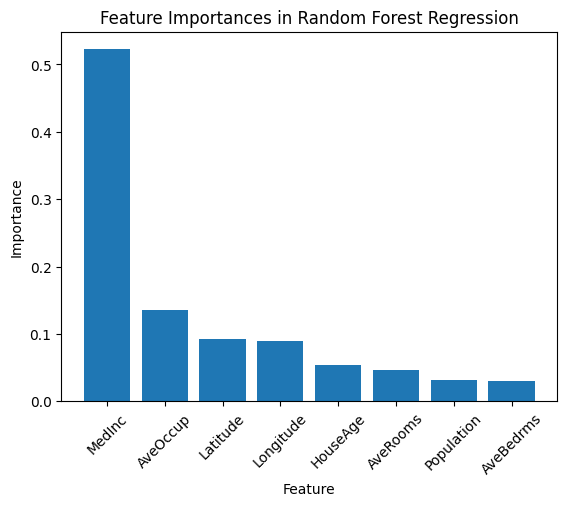

In [21]:
# Feature importances
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]
features = data.feature_names

# Plot feature importances
plt.bar(range(X.shape[1]), importances[indices],  align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances in Random Forest Regression")
plt.show()

In [ ]:
#### Please enter your descriptive answer here and change the cell type to "Markdown" for formatting.


<details><summary>Click here for the solution, part 1</summary>
    
```python
   
# Feature importances
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]
features = data.feature_names

# Plot feature importances
plt.bar(range(X.shape[1]), importances[indices],  align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances in Random Forest Regression")
plt.show()
```


<details><summary>Click here for the solution, part 2</summary>
It makes sense that median incomes and house prices would be correlated, so it's not surprising that median income is the most important feature.

I would think that location must be a significant factor.

Since location is implied by two separate variables, latitude and longitude that share equal importances, we might speculate that location is really the second most important feature.
This is because replacing latitude and longitude with a categorical location at an appropriate level of granularity (suburb, city, etc.) would likely have a combined lat/lng importance, which might outweigh average occupancy.

Might average occupancy and average number of bedrooms be correlated?

A proper analysis of the feature set would include a correlation matrix.
</details>


### Exercise 8. Some final thoughts to consider

- Will the skewness affect the performance of Random Forest regression?
- Does the clipping of median house prices above \$500,000 bias the predictions?
- Also, do we need to standardize the data?


In [ ]:
#### Please enter your descriptive answer here and change the cell type to "Markdown" for formatting.



<details><summary>Click here for the solution</summary>
Compared to linear regression, random forest regression is quite robust against outliers and skewed distributions.
This is because random forest regression doesn't make any assumptions about the data distribution, where linear regression performs best with normally distributed data.

Standardizing the data isn't necessary like it is for distance-based algortihms like KNN or SVMs.

Regarding the clipped vlaues, there is no variablilty in those values. Removing them in preprocessing might help the model to better explain the actual variance in the data.

The clipped values can also bias the predictions.
Also these clipped values can mislead evaluation metrics. As you've learned from this lab, it's crucially important for you to visualize your results.
</details>


## Summary
Congratulations! You're ready to move on to your next lesson!
In this lab, you learned how to implement and assess the performance of random forest regression models using real-world data. You explored evaluation metrics and visualizations to understand the model's effectiveness and examined the feature importances in predicting outcomes. Using the California Housing dataset, you built a random forest regression model to predict median house prices based on various attributes, then evaluated and interpreted the results to understand the factors influencing the predictions.

## Author

<a href="https://www.linkedin.com/in/jpgrossman/" target="_blank">Jeff Grossman</a>


### Other Contributors

<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/" target="_blank">Abhishek Gagneja</a>

<!-- ## Changelog

| Date | Version | Changed by | Change Description |
|:------------|:------|:------------------|:---------------------------------------|
| 2024-11-12 | 1.0  | Jeff Grossman    | Create content |

 -->

## <h3 align="center"> © IBM Corporation. All rights reserved. <h3/>
